# Protein-Protein Interaction (PPI) Network Classifier
## The Question
Proteins are essential to celluar biological functions. The interactions between proteins form a complex network which regulate the cellular process. The biological functions of proteins are very specific, even the same protein in different tissues may have different functions. 
Given certain features of a set of proteins, a set of their interaction networks, and a set of biological function labels, we are interested in whether we can predict the biological functions of proteins in unseen networks, by learning from PPI network structures and features.



## Basic Setup
### PyTorch, PyTorch Geometric, NetworkX, and MatPlotLib
We first load the basic tools. **PyTorch** is the machine learning framework and neural network backend, **PyTorch Geometric** (PyG) is a graph neural network learning extension library for PyTorch. **NetworkX** and **MatPlotLib** are for graph visualization.

In [ ]:
# install PyTorch Geometric
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-geometric

     |████████████████████████████████| 11.9MB 233kB/s 
     |████████████████████████████████| 24.3MB 144kB/s 
     |████████████████████████████████| 194kB 11.8MB/s 
     |████████████████████████████████| 235kB 28.2MB/s 
     |████████████████████████████████| 2.2MB 47.9MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 


In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.utils import (softmax, remove_self_loops, 
                                   add_self_loops, to_dense_adj)
from sklearn.metrics import f1_score

In [ ]:
# visualization utilities
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
# limit the output cell height
from IPython.display import Javascript

## The Data
The PPI dataset was processed by Hamilton et al. (2017) and can be downloaded from [SNAP](http://snap.stanford.edu/graphsage/ppi.zip).
The PyG library already provided a copy of the PPI dataset so we can directly load it.

In [ ]:
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader

train_dataset = PPI('data/PPI', split='train')
val_dataset = PPI('data/PPI', split='val')
test_dataset = PPI('data/PPI', split='test')
# PyG DataLoader can merges data objects to a mini-batch to allow parallel processing
# `batch_size` is the number of examples (graphs) grouped in a mini-batch
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

Extracting data/PPI/ppi.zip
Processing...
Done!


There are 20 graphs in the training dataset, 2 validation graphs and 2 test graphs. 
Each node has 50 features, consists of positional gene sets, motif gene sets and immunological signatures. Each graph corresponds to a specific tissue.

In [ ]:
print(f"Number of graphs in training dataset: {len(train_dataset)}")
print(f"Number of graphs in validation dataset: {len(val_dataset)}")
print(f"Number of graphs in test dataset: {len(test_dataset)}")
print(f"Number of features per node: {train_dataset.num_node_features}")
print(f"Number of classes: {train_dataset.num_classes}")

Number of graphs in training dataset: 20
Number of graphs in validation dataset: 2
Number of graphs in test dataset: 2
Number of features per node: 50
Number of classes: 121


Because each protein can have multiple biological functions, our question is a multi-label classification problem, each node can have several class labels, and is represented as a binary vector of length 121.

In [ ]:
print(train_dataset[0].y.size())
print(train_dataset[0].y[0, :])

torch.Size([1767, 121])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0.])


In [ ]:
def data_stat(dataset):
    '''
    Get the number of nodes, edges per graph.
    '''
    num_nodes = torch.tensor([data.num_nodes for data in dataset])
    num_edges = torch.tensor([data.num_edges for data in dataset])
    return num_nodes, num_edges

In [ ]:
n_train_nodes, n_train_edges = data_stat(train_dataset)
n_val_nodes, n_val_edges = data_stat(val_dataset)
n_test_nodes, n_test_edges = data_stat(test_dataset)

In [ ]:
print(f"# Nodes: {n_train_nodes.sum()+n_val_nodes.sum()+n_test_nodes.sum()}")
print(f"# Edges: {n_train_edges.sum()+n_val_edges.sum()+n_test_edges.sum()}")
print(f"# Training Nodes: {n_train_nodes.sum()}")
print(f"# Validation Nodes: {n_val_nodes.sum()}")
print(f"# Test Nodes: {n_test_nodes.sum()}")

# Nodes: 56944
# Edges: 1587264
# Training Nodes: 44906
# Validation Nodes: 6514
# Test Nodes: 5524


A detailed distribution of number of nodes or edges per graph is shown below.

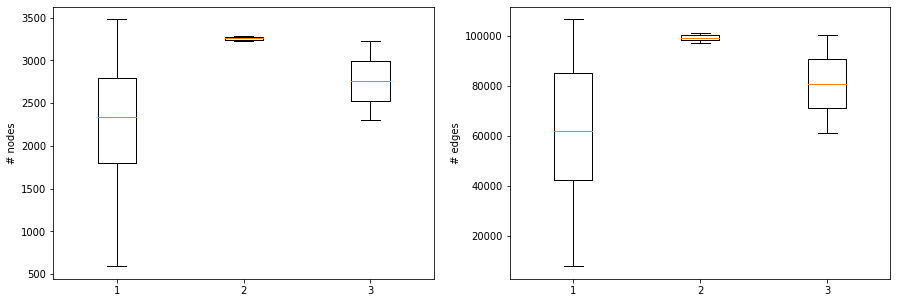

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].boxplot([n_train_nodes.numpy(), n_val_nodes.numpy(), n_test_nodes.numpy()])
axes[0].set_ylabel("# nodes")
axes[1].boxplot([n_train_edges.numpy(), n_val_edges.numpy(), n_test_edges.numpy()])
axes[1].set_ylabel("# edges")
plt.show()

## Graph Attention Networks

Since PPI is naturally a graph, my first thought is to use graph convolutional networks (GCN).
However, there are two limitations of GCN.
The first limitation is GCN optimization depends on the global graph structure, since the graph Laplacian is needed. Thus it may not generalize well to completely unseen graph.

Another limitation of GCN is that it assgins equal importance of self-loops and edges to neighboring nodes. 
The normaliztion constant solely depends on the graph structure, i.e. $\frac{1}{\sqrt{deg(v_i) deg(v_j)}}$.

This may not be a problem when most neighbors are equally important. 
But the assumption will not hold for every datasets. 
Back to our question, the protein-protein interactions are specific, that means the interaction between two proteins occurs at certain binding domains, and have particular biological function.
Two proteins interact with the same third protein may bind to different domains and thus have entirely different functions. 
Therefore, it seems for our question, the equal importance assumption is **unlikely** to be true.

So is there a way to assign **arbitrary importances** to different neighbors? The answer is yes, that is **graph attention networks** (GAT, Veličković et al. 2017), it employs self-attention mechanism to allow each node find out which neighbors they should pay more attention to (give higher importance).


We define $\vec{h}_i^{(l)}$ as the feature vector of node $i$ at layer $l$, $\mathbf{W}$ is the shared node-wise weight matrix, $\mathcal{N}_i$ as the neighborhood of node $i$, and $\alpha_{ij}$ as the importance of node $j$'s feature to node $i$ at layer $l$.
$$\vec{h}_i^{(l+1)} = \sigma \left( \sum_{j \in \mathcal{N}_i} \alpha_{ij}\mathbf{W}\vec{h}_j^{(l)} \right)$$
Instead of explicitly defined the importance $\alpha_{ij}$ or as learnable weight, the authors **implicitly** define $\alpha_{ij}$ by employing self-attention mechanism $a$:
$$e_{ij} = a \left( \mathbf{W}\vec{h}_i^{(l)}, \mathbf{W}\vec{h}_j^{(l)} \right)$$
Here, $a$ is single-layer neural network with weight vector $\vec{\mathbf{a}}$ and nonliear function $\text{LeakyReLU}$ i.e. a leaky version of a ReLU allows a small gradient on negative input:
$$e_{ij} = \text{LeakyReLU}\left( {\vec{\mathbf{a}}}^T \left[ \mathbf{W}\vec{h}_i^{(l)} \parallel \mathbf{W} \vec{h}_j^{(l)} \right] \right)$$
where $\parallel$ is the concatenation operation.

Then, $e_{ij}$ is normalized across all choices of $j$ from $\mathcal{N}_i$:
$$\alpha_{ij} = \mbox{softmax}_j (e_{ij}) =  \frac{\mbox{exp}(e_{ij})}{\sum_{k\in\mathcal{N}_i} \mbox{exp} (e_{ik})}$$

### Regularization by Multi-Head Attention
The authors further proposed a regularization process by applying $K$ independent attention mechanisms with different parameters, then aggregate by either concatenating (hidden layer) or averaging (output layer) together:
$$\mbox{Concatenate}: \vec{h}_i^{(l+1)} = \; \parallel_{k=1}^K \sigma \left( \sum_{j \in \mathcal{N}_i} \alpha_{ij}^{k} \mathbf{W}^{k}\vec{h}_j^{(l)} \right)$$
$$\mbox{Average}: \vec{h}_i^{(l+1)} = \sigma \left( \frac{1}{K} \sum_{k=1}^K \sum_{j \in \mathcal{N}_i} \alpha_{ij}^{k} \mathbf{W}^{k}\vec{h}_j^{(l)} \right)$$

### Pytorch Geometric Implementation
PyG has already implemented the graph attention layer for us, let's take a look at its interface:
```
CLASS GATConv(in_channels, out_channels, heads=1, concat=True, negative_slope=0.2, dropout=0, ...)
```
- **heads** define the number of independent attention mechanisms applied (i.e. $K$)
- **concat** define the multi-head aggregation method (`True` for concatenate, `False` for average)
- **negative_slope** define the negative slope of the LeakyReLU
- **dropout** define the dropout probability of attentions in training

To allow access to the attentions $\alpha_{ij}$ for further evaluation, I override the `message` method as suggested in [Attention Quality in GAT](https://github.com/rusty1s/pytorch_geometric/issues/482):

In [ ]:
class GATConvA(GATConv):
    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):
        alpha = alpha_j if alpha_i is None else alpha_j + alpha_i
        alpha = F.leaky_relu(alpha, self.negative_slope)
        alpha = softmax(alpha, index, ptr, size_i)
        self._alpha = alpha
        self.alpha = alpha.detach() # add this line to save attention for later access
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return x_j * alpha.unsqueeze(-1)

In the paper, the authors proposed a three-layer GAT model:
- The first two layers consist of $K=4$ attention heads, each computing feature of length 256
    - heads are aggregated by concatenation, resulting feature of length 1024
    - followed by an nonlinear function **ELU**
- The output layer consists of $K=6$ attention heads, each computing feature of length 121 (the number of classes)
    - heads are aggregated by average
    - followed by a **logistic sigmoid** activation

A notable step in their implementation is they employed **skip connections** similar to ResNet, which is known to alleviate the vanishing gradient problem.

The network is trained to minimize cross-entropy loss for multi-label classification using Adam SGD optimizer, and evaluated by **F1 score**.

In [ ]:
class GATNet(torch.nn.Module):
    def __init__(self, hidden_channels, num_classes):
        super(GATNet, self).__init__()
        self.conv1 = GATConvA(hidden_channels, 256, heads=4)
        self.lin1 = torch.nn.Linear(hidden_channels, 4 * 256)
        self.conv2 = GATConvA(4 * 256, 256, heads=4)
        self.lin2 = torch.nn.Linear(4 * 256, 4 * 256)
        self.conv3 = GATConvA(4 * 256, num_classes, heads=6,
                             concat=False)
        self.lin3 = torch.nn.Linear(4 * 256, num_classes)

    def forward(self, x, edge_index, skip_connection=True):
        if skip_connection:
            x = F.elu(self.conv1(x, edge_index) + self.lin1(x))
            x = F.elu(self.conv2(x, edge_index) + self.lin2(x))
            x = self.conv3(x, edge_index) + self.lin3(x)
        else:
            x = F.elu(self.conv1(x, edge_index))
            x = F.elu(self.conv2(x, edge_index))
            x = self.conv3(x, edge_index)
        if not self.training:
          return x, self.conv1.alpha
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use GPU if available

In [ ]:
loss_op = torch.nn.BCEWithLogitsLoss()

In [ ]:
def train(model, optimizer, skip_connection=True):
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        # perform one forward pass and calculate cross entropy loss
        loss = loss_op(model(data.x, data.edge_index, skip_connection), data.y)
        total_loss += loss.item() * data.num_graphs
        # update weights by gradients
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)

In [ ]:
@torch.no_grad()
def test(model, loader, skip_connection=True):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        out, alpha = model(data.x.to(device), data.edge_index.to(device), skip_connection)
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0, alpha, data

Without skip-connection:

In [ ]:
# limit the output cell height to 200
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 200})'''))

model = GATNet(train_dataset.num_features, train_dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
for epoch in range(1, 21):
    loss = train(model, optimizer, False)
    val_f1, _, _ = test(model, val_loader)
    print('Epoch: {:02d}, Loss: {:.4f}, Val F1 score: {:.4f}'.format(epoch, loss, val_f1))

<IPython.core.display.Javascript object>

Epoch: 01, Loss: 0.6470, Val F1 score: 0.4215
Epoch: 02, Loss: 0.5659, Val F1 score: 0.4324
Epoch: 03, Loss: 0.5595, Val F1 score: 0.4317
Epoch: 04, Loss: 0.5554, Val F1 score: 0.4489
Epoch: 05, Loss: 0.5491, Val F1 score: 0.4441
Epoch: 06, Loss: 0.5472, Val F1 score: 0.4526
Epoch: 07, Loss: 0.6005, Val F1 score: 0.3834
Epoch: 08, Loss: 0.6424, Val F1 score: 0.4116
Epoch: 09, Loss: 0.6030, Val F1 score: 0.4139
Epoch: 10, Loss: 0.5593, Val F1 score: 0.4096
Epoch: 11, Loss: 0.5577, Val F1 score: 0.4391
Epoch: 12, Loss: 0.5569, Val F1 score: 0.4092
Epoch: 13, Loss: 0.5567, Val F1 score: 0.4005
Epoch: 14, Loss: 0.5563, Val F1 score: 0.4126
Epoch: 15, Loss: 0.5548, Val F1 score: 0.3925
Epoch: 16, Loss: 0.5558, Val F1 score: 0.4188
Epoch: 17, Loss: 0.5565, Val F1 score: 0.4092
Epoch: 18, Loss: 0.5565, Val F1 score: 0.4103
Epoch: 19, Loss: 0.5564, Val F1 score: 0.4065
Epoch: 20, Loss: 0.5565, Val F1 score: 0.4161


In [ ]:
test_f1, _, _ = test(model, test_loader, False)
print('Test F1 score: {:.4f}'.format(test_f1))

Test F1 score: 0.4053


With skip-connection:

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 200})'''))

model = GATNet(train_dataset.num_features, train_dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

for epoch in range(1, 101):
    loss = train(model, optimizer, True)
    val_f1, _, _ = test(model, val_loader)
    print('Epoch: {:02d}, Loss: {:.4f}, Val F1 score: {:.4f}'.format(epoch, loss, val_f1))

<IPython.core.display.Javascript object>

Epoch: 01, Loss: 0.8541, Val F1 score: 0.4829
Epoch: 02, Loss: 0.5353, Val F1 score: 0.5441
Epoch: 03, Loss: 0.5069, Val F1 score: 0.4859
Epoch: 04, Loss: 0.4846, Val F1 score: 0.5881
Epoch: 05, Loss: 0.4706, Val F1 score: 0.5999
Epoch: 06, Loss: 0.4514, Val F1 score: 0.6246
Epoch: 07, Loss: 0.4299, Val F1 score: 0.6095
Epoch: 08, Loss: 0.4002, Val F1 score: 0.6562
Epoch: 09, Loss: 0.3793, Val F1 score: 0.6492
Epoch: 10, Loss: 0.3582, Val F1 score: 0.6733
Epoch: 11, Loss: 0.3366, Val F1 score: 0.7355
Epoch: 12, Loss: 0.3008, Val F1 score: 0.7574
Epoch: 13, Loss: 0.2765, Val F1 score: 0.7804
Epoch: 14, Loss: 0.2584, Val F1 score: 0.7873
Epoch: 15, Loss: 0.2331, Val F1 score: 0.8210
Epoch: 16, Loss: 0.2113, Val F1 score: 0.8254
Epoch: 17, Loss: 0.2069, Val F1 score: 0.8333
Epoch: 18, Loss: 0.1903, Val F1 score: 0.8543
Epoch: 19, Loss: 0.1709, Val F1 score: 0.8710
Epoch: 20, Loss: 0.1573, Val F1 score: 0.8775
Epoch: 21, Loss: 0.1452, Val F1 score: 0.8769
Epoch: 22, Loss: 0.1429, Val F1 sc

In [ ]:
test_f1, alpha, data = test(model, test_loader, True)
print('Test F1 score: {:.4f}'.format(test_f1))

Test F1 score: 0.9746


We can see that use skip-connection can greatly improve the model performance.

### Understanding Attention Heads Learned
To better understand the reason why GAT performs better than GCN, let's take a look at the attention $\alpha_{ij}$ it learned.

First, let's visualize how the incoming attention distribute for a single node at the first layer.

In [ ]:
alpha = alpha.to('cpu')
print(alpha.size())

torch.Size([167500, 4])


The size of $\alpha$ is actually larger than the number of edges in the test dataset, because the model added self-loops to the graph. So first we need to apply the same process to the edge set from data. 

In [ ]:
edge_index = data.edge_index
num_nodes = data.x.size(0)
edge_index, _ = remove_self_loops(edge_index)
edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)

In [ ]:
def to_adj(k):
    '''
    Convert edge set (edge_index) and `k`-th attention head (alpha) 
    to a weighted adjacency matrix.
    '''
    return to_dense_adj(edge_index, edge_attr=alpha[:, k])[0]

The first layer has 4 attention heads, convert each to a dense weighted adjacency matrix.

In [ ]:
a0 = to_adj(0)
a1 = to_adj(1)
a2 = to_adj(2)
a3 = to_adj(3)

In [ ]:
def plot_incoming_attention(a, k):
    '''
    Draw incoming edges graph of node `k`,
    edges are colored by their attention values `a`.
    '''
    G = nx.DiGraph() # initialize a directed graph
    # gather the neighbors of node k
    node_list = (a[:, k] > 0).nonzero(as_tuple=False).view(-1).numpy()
    G.add_nodes_from(node_list) # add nodes to graph G
    # add edges to graph G
    for i in range(a.size(0)):
        if a[i, k] > 0:
            G.add_edge(i, k)
    # generate node positions using force-directed algorithm
    pos = nx.spring_layout(G, seed=12345)
    # set the edge color by attention value
    edge_colors = a[:, k][node_list].numpy()
    cmap = plt.cm.OrRd
    node_size = 30
    # draw nodes
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size, 
                                node_color="indigo")
    # draw edges
    edges = nx.draw_networkx_edges(
        G, 
        pos,
        node_size=node_size,
        arrowstyle='->',
        arrowsize=10,
        edge_color=edge_colors,
        edge_cmap=cmap,
        width=2,
    )
    # draw node labels
    nx.draw_networkx_labels(G, pos, 
                            {x: str(x) for x in node_list},
                            font_size=12)
    pc = mpl.collections.PatchCollection(edges, cmap=cmap)
    pc.set_array(edge_colors)
    pc.set_clim(vmin=0, vmax=1)
    plt.colorbar(pc)

    ax = plt.gca()
    ax.set_axis_off()

Then let's draw the learned attention of node 0 over its incoming edges, and color the edges by their attention value.

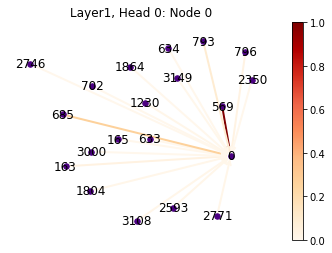

In [ ]:
plot_incoming_attention(a0, 0)
plt.title("Layer1, Head 0: Node 0")
plt.show()

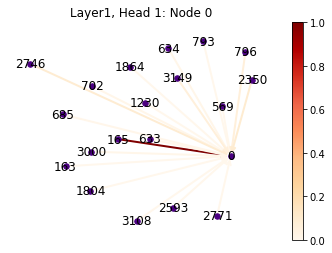

In [ ]:
plot_incoming_attention(a1, 0)
plt.title("Layer1, Head 1: Node 0")
plt.show()

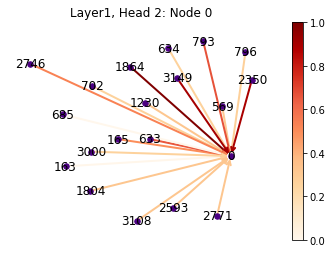

In [ ]:
plot_incoming_attention(a2, 0)
plt.title("Layer1, Head 2: Node 0")
plt.show()

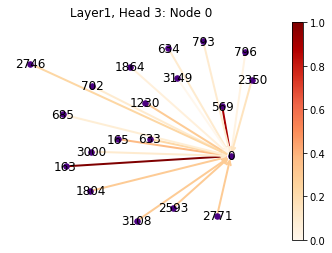

In [ ]:
plot_incoming_attention(a3, 0)
plt.title("Layer1, Head 3: Node 0")
plt.show()

From the four graphs, we can see that different attention heads show distinct pattern, each favors different neighbors.
For most heads, the attentions are not uniformly distributed among the neighborhood, i.e. only a small subset of neighboring nodes have very high importance.

A more quantitative analysis is to calculate the entropy of the attention distribution over the incoming edges to each node.
$$H(\alpha_i) = - \sum_{j\in \mathcal{N}_i} \alpha_{ij} \log_2{\alpha_{ij}}$$

In [ ]:
def entropy(a):
    '''
    Calculate the entropy of attention `a` column-wise
    '''
    log_a = torch.log2(a)
    log_a[torch.isinf(log_a)] = float('nan')
    return - torch.nansum(a * log_a, dim=0).numpy()

Draw the histograms of attention entropy for each head. 

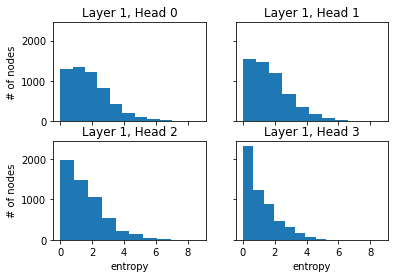

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
axes[0, 0].hist(entropy(a0))
axes[0, 0].set_title("Layer 1, Head 0")
axes[0, 1].hist(entropy(a1))
axes[0, 1].set_title("Layer 1, Head 1")
axes[1, 0].hist(entropy(a2))
axes[1, 0].set_title("Layer 1, Head 2")
axes[1, 1].hist(entropy(a3))
axes[1, 1].set_title("Layer 1, Head 3")
plt.setp(axes[-1, :], xlabel="entropy")
plt.setp(axes[:, 0], ylabel="# of nodes")
plt.show()

As a reference, simulate the case when the attention distribution is uniform for all nodes.

In [ ]:
rand_a = torch.rand(edge_index.size(1))
rand_a = to_dense_adj(edge_index, edge_attr=rand_a)[0]
rand_a = rand_a / rand_a.sum(dim=0) # normalize column-wise so each column sum to 1

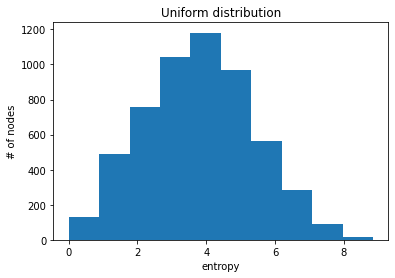

In [ ]:
plt.hist(entropy(rand_a))
plt.title("Uniform distribution")
plt.xlabel("entropy")
plt.ylabel("# of nodes")
plt.show()

As we can see, the actual attention entropy distribution is completely skewed compare to uniform distribution. 
It's likely that the learned attention can help the model assgin more importaince to more relevant neighboring nodes, therefore making it performs better than GCN.

## Reference

1. Hamilton, W., Ying, Z., & Leskovec, J. (2017). Inductive representation learning on large graphs. In Advances in neural information processing systems (pp. 1024-1034).

2. Veličković, P., Cucurull, G., Casanova, A., Romero, A., Lio, P., & Bengio, Y. (2017). Graph attention networks. arXiv preprint arXiv:1710.10903.

3. Kipf, T. N., & Welling, M. (2016). Semi-supervised classification with graph convolutional networks. arXiv preprint arXiv:1609.02907.

4. https://docs.dgl.ai/tutorials/models/1_gnn/9_gat.html

5. https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html